<a href="https://colab.research.google.com/github/RVel37/STRCalculator/blob/master/Day_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pre-learning

In [3]:
install.packages("ggplot2")
library(ggplot2)

df <- c(5,7,9,10,11)
n_iterations <- 1000

bootstrap_means <- numeric(n_iterations)

set.seed(42)
for (i in 1:n_iterations) {
  bootstrap_sample <- sample(data, size=length(data), replace=TRUE)
  bootstrap_means[i] <-mean(bootstrap_sample)
}

lower <- quantile (bootstrap_means, 0.025)
upper <- quantile(bootstrap_means, 0.975)
cat("bootstrap 95% CI for mean: ", lower, "to", upper, "\n")

# make into DF
plot_df <- data.frame(
  iteration = 1:n_iterations,
  mean = bootstrap_means,
  lower = lower,
  upper = upper
)

# plot data
ggplot(data.frame(mean = bootstrap_means), aes(x = mean)) +
  geom_histogram(bins = 30, alpha = 0.6) +
  geom_vline(xintercept = lower, color = "red") +
  geom_vline(xintercept = upper, color = "red")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



ERROR: Error in x[sample.int(length(x), size, replace, prob)]: object of type 'closure' is not subsettable


In [ ]:
library(ggplot2)

group1 <- c(5,7,8)
group2 <- c(6,9,10)
observed_diff <- mean(group1) - mean(group2)

combined <- c(group1,group2)
n <- length(group1)

n_permutations <- 1000
permuted_diffs <- numeric(n_permutations)

set.seed(42)
for (i in 1:n_permutations) {
  permuted <- sample(combined)
  permuted_diffs[i] <- mean(permuted[1:n]) - mean(permuted[(n+1):length(permuted)])
}

p_value <- mean(abs(permuted_diffs) >= abs(observed_diff))

cat("observed difference: ", observed_diff, "\n")
cat("p-value: ", p_value, "\n")

# df + plot
df <- data.frame(permuted_diffs = permuted_diffs)

ggplot(df, aes(x = permuted_diffs)) +
  geom_density(color = "green") +
  #geom_vline(xintercept = observed_diff, color = "blue") +
  labs(title = "Permutation Distribution",
       x = "Difference in Means")


## **Whole Network Entropy** (**Day 3**)

# **IMPORTANT!** Before we begin, change runtime type to R

### **1. Load in data**

In [4]:
exp_data <- read.csv('/content/X.csv', header=FALSE)
metadata <-read.csv('/content/obs.csv')
var_data<- read.csv('/content/var.csv')

rownames(exp_data)<-metadata$CellID
colnames(exp_data)<-var_data$Gene


### **2. Create Metadata and Expression data for the 3 cell types; Secretory Epithelial-1, Secretory Epithelial-2, STIC lesion**

Use `dplyr` to select 3 cell types for our analysis (we've chosen SE1, 2, and STIC lesions).

In [5]:
install.packages("dplyr")
library(dplyr)
metadata_SE1 <- metadata[metadata$Celltype %in% c('Secretory Epithelial-1'),]
exp_data_SE1 <- exp_data[rownames(exp_data) %in% metadata_SE1$CellID,]

metadata_SE2 <- metadata[metadata$Celltype %in% c('Secretory Epithelial-2'),]
exp_data_SE2 <- exp_data[rownames(exp_data) %in% metadata_SE2$CellID,]

metadata_STIC <- metadata[metadata$Celltype %in% c('STIC lesion'),]
exp_data_STIC <- exp_data[rownames(exp_data) %in% metadata_STIC$CellID,]

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘dplyr’


The following object is masked from ‘package:Biobase’:

    combine


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, setequal, union


The following object is masked from ‘package:generics’:

    explain


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




### **3. Entropy Analysis**

From the expression data of each cell type we would sample 50 genes and calculate the entropy of the expression levels of the 50 genes. Sampling will be iterated 100 times. Finally a boxplot will be plotted to represent the 100 entropy values in each cell type.


*   **Entropy**: Entropy **quantifies the amount of uncertainty or randomness in information content** (e.g. gene expression).
"Shannon Entropy": introduced by Claude Shannon, it is the average number of bits required to encode a message or the unpredictability of a data source.

  - **High** entropy: A message is highly unpredictable or random (e.g. highly variable gene)
  
  - **Low** entropy: A message is predictable or repetitive
  - Example: A fair coin flip has 1 bit of entropy per flip because there are two equally likely outcomes (heads or tails).
*   **Sampling/Subsampling**: A technique used to extract a smaller subset of data (a "subsample") from a larger sample or dataset. It is often employed to reduce computational complexity, test robustness, or handle large datasets efficiently without analyzing the entire sample.

* **Purpose**: To provide better coverage of the network. Calculating a single entropy of the entire network could mask clusters/areas of very high or low entropy.

For purposes of DEG analysis:
We know genes work in networks - if we were to just measure entropy of whole network, we'll just get one number as an output. But some subnetworks might have more intense/direct differential expression, with lower entropy.
To get this info, we subset (different resolutions of network)

NOTE: entropy is extremely sensitive to end number - so need to use same number in each cell. can't take overall entropy of one cell type then compare to another, because we'll get different numbers of genes. Which is why we must subsample.

Bayesian analysis will do more clever analytical work.

In [6]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("BioQC")
library(BioQC)

# transpose
exp_data_SE1 <- t(exp_data_SE1)
exp_data_SE2 <- t(exp_data_SE2)
exp_data_STIC <- t(exp_data_STIC)

compilation_SE1 <- data.frame()

# create 100 subsamples, calculate entropy from sample of 50 different cells
# and put in dataframe ("compilation SE1, SE2, STIC")
for (x in 1:100) {
  n <- sample(1:nrow(exp_data_SE1), 50, replace=FALSE)
  test <- exp_data_SE1[n,]
  entropy <- BioQC::entropy(test)
  samples <- append(n,entropy)
  compilation_SE1 <- rbind(compilation_SE1, samples)
}

compilation_SE2 <- data.frame()

for (x in 1:100) {
  n <- sample(1:nrow(exp_data_SE2), 50, replace=FALSE)
  test <- exp_data_SE2[n,]
  entropy <- BioQC::entropy(test)
  samples <- append(n,entropy)
  compilation_SE2 <- rbind(compilation_SE2, samples)
}

compilation_STIC <- data.frame()

for (x in 1:100) {
  n <- sample(1:nrow(exp_data_STIC), 50, replace=FALSE)
  test <- exp_data_STIC[n,]
  entropy <- BioQC::entropy(test)
  samples <- append(n,entropy)
  compilation_STIC <- rbind(compilation_STIC, samples)
}

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.22 (BiocManager 1.30.27), R 4.5.2 (2025-10-31)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'BioQC'”
Old packages: 'broom', 'bslib', 'cpp11', 'data.table', 'rappdirs', 'uuid',
  'vctrs', 'vroom', 'xfun', 'xml2'



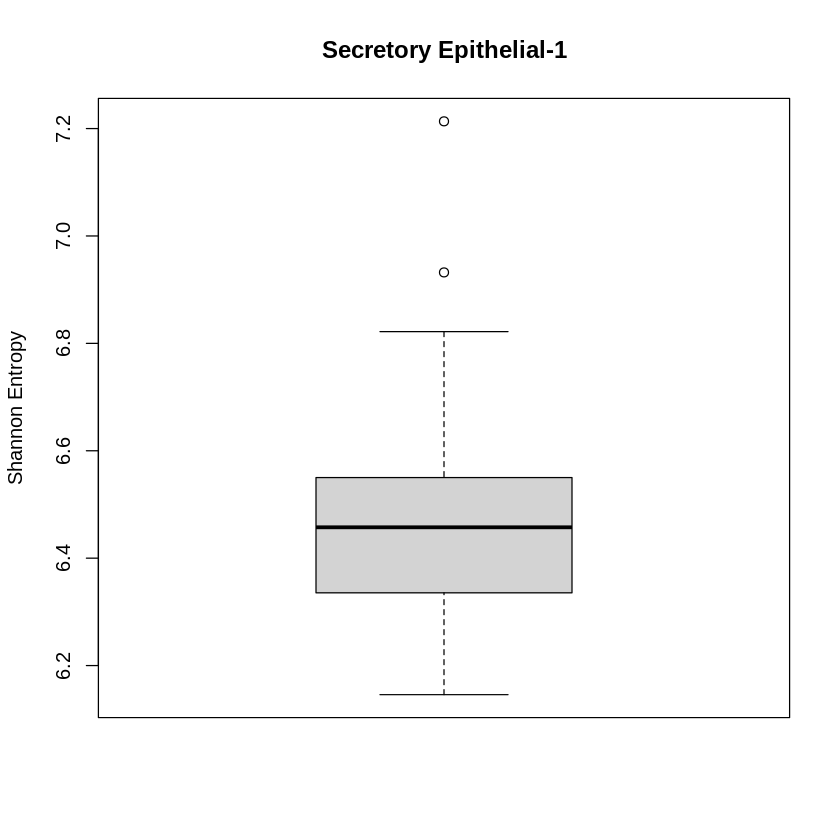

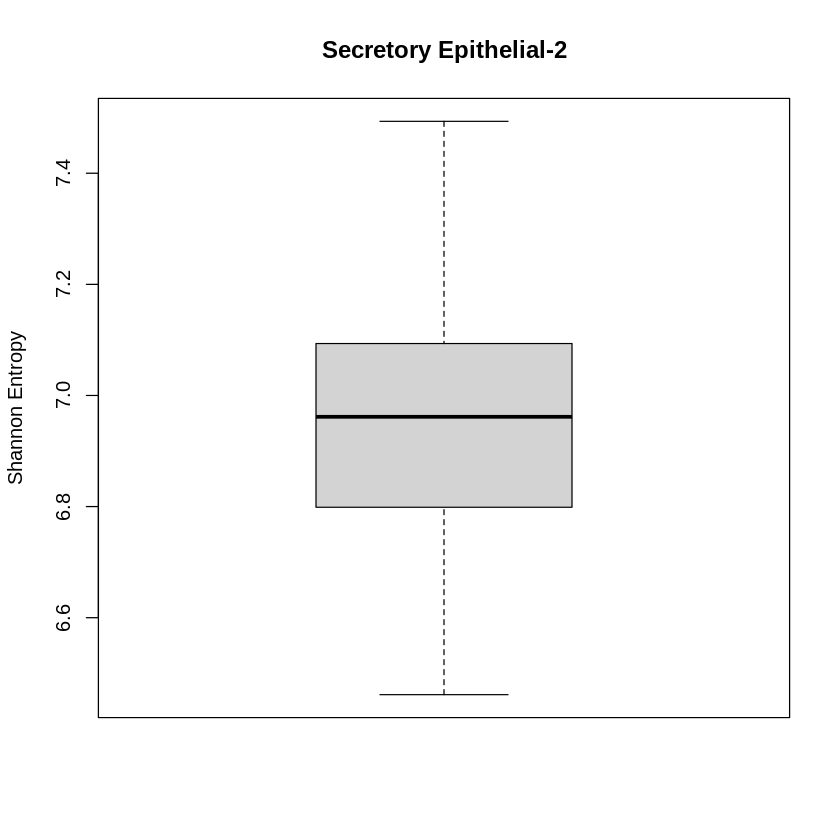

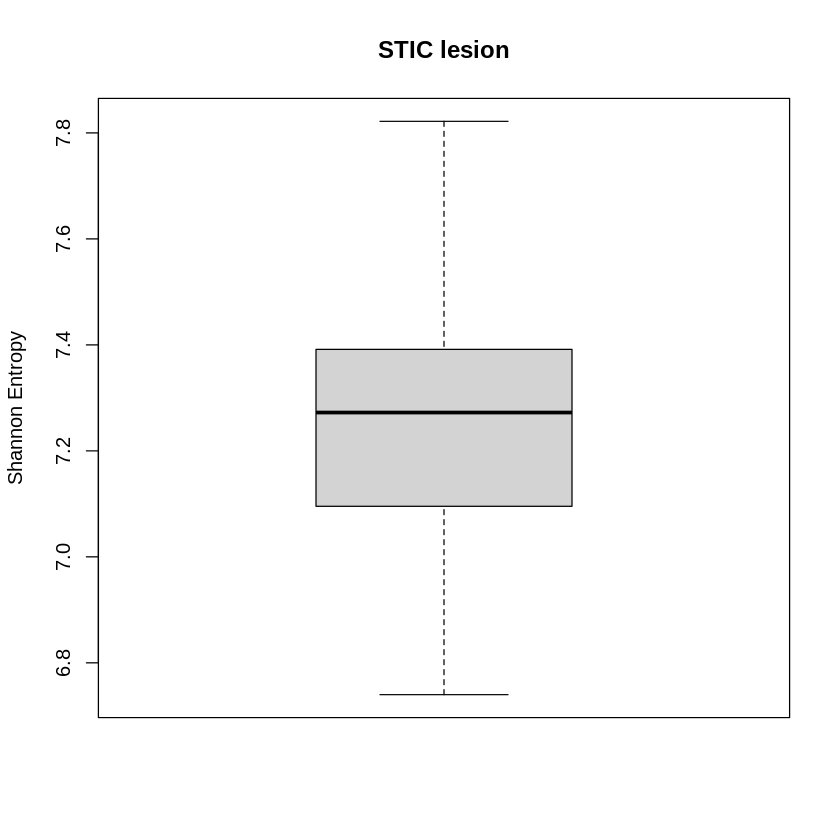

In [7]:
colnames(compilation_SE1) <- c(paste0("f", 1:50), "Entropy")
boxplot(compilation_SE1$Entropy,
        main="Secretory Epithelial-1",
        ylab="Shannon Entropy")

colnames(compilation_SE2) <- c(paste0("f", 1:50), "Entropy")
boxplot(compilation_SE2$Entropy,
        main="Secretory Epithelial-2",
        ylab="Shannon Entropy")

colnames(compilation_STIC) <- c(paste0("f", 1:50), "Entropy")
boxplot(compilation_STIC$Entropy,
        main="STIC lesion",
        ylab="Shannon Entropy")

### **4. Bayesian Analysis**

Select 2 cell types to determine how different they are based on the entropy values.

* **Bayesian Statistics**: An approach to statistical inference that uses probability to quantify uncertainty and incorporates prior knowledge or beliefs into the analysis. This framework contrasts with frequentist statistics, which relies solely on observed data without incorporating prior beliefs. Bayesian methods are particularly useful in situations involving uncertainty, limited data, or complex models.

  - Prior Distribution: Represents initial beliefs about parameters before observing data.
Can be subjective (based on expert knowledge) or non-informative (flat or uniform to express no strong initial belief).
  - Likelihood : Describes how likely the observed data is, assuming a particular hypothesis.
  - Posterior Distribution: Combines the prior and likelihood to provide the updated belief about the hypothesis.
  - Bayesian Updating: As new data is observed, the posterior from one analysis becomes the prior for the next. This iterative process refines estimates over time.

In [ ]:
install.packages("BayesFactor")
library(BayesFactor)

bayes_SE1 <-  ttestBF(x= compilation_SE1$Entropy, posterior = TRUE ,iterations = 1000)

bayes_STIC <-  ttestBF(x= compilation_STIC$Entropy, posterior = TRUE ,iterations = 1000)

bayes_SE1_STIC <-  ttestBF(x= compilation_STIC$Entropy, y=compilation_SE1$Entropy,
                           posterior = TRUE ,iterations = 1000, paired = TRUE)

post_SE1<- data.frame(mu = as.numeric(bayes_SE1[,"mu"]), Posterior = 'Secretory Epithelial-1')
post_STIC<- data.frame(mu = as.numeric(bayes_STIC[,"mu"]), Posterior = 'STIC lesion')
post_SE1_STIC<- data.frame(mu = as.numeric(bayes_SE1_STIC[,"mu"]), Posterior = 'Secretory Epithelial-1 & STIC lesion')

**Plot Posterior distribution**

* **Confidence Interval**: This is the range of values you expect your estimate to fall between if you redo your test, within a certain level of confidence. The interval is defined by the confidence level, which is the percentage of times you expect to reproduce an estimate between the upper and lower bounds of the confidence interval. Here the confidence level is set at 95%, thus you can be confident that 95 out of 100 times the estimate will fall between the upper and lower values specified by the confidence interval.

In [ ]:
install.packages("ggplot2")
library(ggplot2)

plot_post_SE1 <- ggplot(post_SE1, aes(x=mu))+
  geom_histogram(color="darkblue", fill="lightblue") +
  ggtitle("Secretory Epithelial-1")

plot_post_STIC <- ggplot(post_STIC, aes(x=mu))+
  geom_histogram(color="red", fill="pink") +
  ggtitle("STIC lesion")

plot_post_SE1_STIC <- ggplot(post_SE1_STIC, aes(x=mu))+
  geom_histogram(color="darkgreen", fill="green") +
  geom_vline(xintercept = as.numeric(ci95[1:2]), linetype="dashed",
             color = "black", size=1, ) +
  ggtitle("Secretory Epithelial-1 & STIC lesion")


plot_post_SE1
plot_post_STIC
plot_post_SE1_STIC

# **Try Part 4 and Part 5 yourself with a different combination of the 2 cell types**

Select 2 cell types for analysis. Replace "choice" to selected cell types.

In [ ]:
bayes_SE1 <-  ttestBF(x= compilation_SE1$Entropy, posterior = TRUE ,iterations = 1000)
plot(bayes_SE1[,"mu"])

bayes_SE2 <-  ttestBF(x= compilation_SE2$Entropy, posterior = TRUE ,iterations = 1000)
plot(bayes_SE2[,"mu"])

bayes_SE1_SE2 <-  ttestBF(x= compilation_SE1$Entropy, y=compilation_SE2$Entropy,
                           posterior = TRUE ,iterations = 1000, paired = FALSE)

post_SE1<- data.frame(mu = as.numeric(bayes_SE1[,"mu"]), Posterior = 'SE 1')
post_SE2<- data.frame(mu = as.numeric(bayes_SE2[,"mu"]), Posterior = 'SE 2')
post_SE1_SE2<- data.frame(mu = as.numeric(bayes_SE1_SE2[,"mu"]), Posterior = 'SE 1 & SE 2')

In [ ]:
library(HDInterval)
ci95<-hdi(post_SE1_SE2)

library(ggplot2)

plot_post_SE1 <- ggplot(post_SE1, aes(x=mu))+
  geom_histogram(color="darkblue", fill="lightblue")+
  ggtitle("SE1")

plot_post_SE2 <- ggplot(post_SE2, aes(x=mu))+
  geom_histogram(color="red", fill="pink")+
  ggtitle("SE2")

plot_post_SE1_SE2 <- ggplot(post_SE1_SE2, aes(x=mu))+
  geom_histogram(color="darkgreen", fill="green") +
  geom_vline(xintercept = ci95, linetype="dashed",
             color = "black", size=1, )+
  ggtitle("SE1 & SE2")

plot_post_SE1
plot_post_SE2
plot_post_SE1_SE2